# End-to-end example

...with neural networks!

Let's walk through a simple example with a more complicated model.

**Takeaways:**

* Use high quality features!
* Demo of "shallow" neural network.

## Data

Let's use [UW's Breast Cancer data][1]:

[1]:https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

data = load_breast_cancer()
df = pd.DataFrame(data["data"], columns=data["feature_names"])
df["malign"] = 1 - data["target"]
print("Malign:", df.malign.sum())
print("Benign:", len(df) - df.malign.sum())
df.head()

Malign: 212
Benign: 357


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,malign
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


These features look pretty detailed.

This data could come from a CSV too:

In [2]:
# df = pd.read_csv("cancer_data.csv")

Okay, let's collect the training data:

In [3]:
target = "malign"

cols = [c for c in df.columns if c != target]
X = df[cols].to_numpy().astype("float32")
y = df[target].to_numpy().astype("int64")

n, d = X.shape

In [4]:
f"The training set has {n} examples and {d} features"

'The training set has 569 examples and 30 features'

## Model

In [5]:
import torch.nn as nn
import torch

class FullyConnected(nn.Module):
    def __init__(self, features=30, depth=2):
        super().__init__()
        self.first_layer = nn.Linear(features, 2 * features)
        self.layers = [nn.Linear(2 * features, 2 * features) for _ in range(depth - 2)]
        self.last_layer = nn.Linear(2 * features, 1)
    
    def forward(self, x):
        x = torch.relu(self.first_layer(x))
        for layer in self.layers:
            x = torch.relu(layer(x))
        return torch.tanh(self.last_layer(x))

This model is a feature transformer – it takes a vector and transforms it a couple times. By default, it does this behavior:

1. Input 30 numbers
2. Transform to 60 numbers
3. Transform to 1 number


In [6]:
module = FullyConnected()
n_params = sum([x.nelement() for x in module.parameters()])
f"This instance of FullyConnected has {n_params} parameters"

'This instance of FullyConnected has 1921 parameters'

It has more parameters/weights than examples. In the case of lienar models, this would mean a *perfect* training fit but horrible test performance.

## Training

**This is clearly non-convex:** there are products of weights and two non-linearities.

In [7]:
from utils import Optimizer
import torch.optim as optim
import numpy as np

est = Optimizer(
    module=FullyConnected,
    module__depth=3,
    criterion=nn.SoftMarginLoss,
    optimizer=optim.Adadelta,
    optimizer__weight_decay=1e-6,
    max_epochs=1000,
)

The docs for [SoftMarginLoss][1] say the targets should be +1 or -1. It's basically hinge loss (as shown in demo 0).

[1]:https://pytorch.org/docs/stable/generated/torch.nn.SoftMarginLoss.html#torch.nn.SoftMarginLoss

In [8]:
y2 = 2 * y - 1
np.unique(y2)

array([-1,  1])

Before we fit the estimator, we need to make sure each feature has 0 mean and unit variance:

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

This is extremely common (e.g., [it's in PyTorch's MNIST example][2] or [this SO question][3]).

[3]:https://stackoverflow.com/questions/63746182/correct-way-of-normalizing-and-scaling-the-mnist-dataset
[2]:https://github.com/pytorch/examples/blob/2639cf050493df9d3cbf065d45e6025733add0f4/mnist/main.py#L114

In [10]:
est.fit(X_train, y_train.reshape(-1, 1))

<class 'skorch.net.NeuralNet'>[initialized](
  module_=FullyConnected(
    (first_layer): Linear(in_features=30, out_features=60, bias=True)
    (last_layer): Linear(in_features=60, out_features=1, bias=True)
  ),
)

In [11]:
model_out = est.predict(X_test)
y_pred = np.sign(model_out).flatten()
acc = (y_pred == y_test).mean()
f"Our classifier is {100 * acc:0.1f}% accurate"

'Our classifier is 96.5% accurate'

1. First try: 93.0% accuracy.
    * That's a probably a sign that these features are *very* informative.
2. Second try (training longer; max_epochs=200 → max_epochs=800): 96.5%
3. Third try (depth=2 → depth=3): 97.2%

In [12]:
from sklearn.linear_model import LogisticRegression

baseline = LogisticRegression()
baseline.fit(X_train, y_train)
acc = baseline.score(X_test, y_test)
f"Baseline accuracy is {100 * acc:0.1f}%"

'Baseline accuracy is 97.9%'

But the baseline model is *linear.* That means finding feature importance is easy:

Text(0.5, 1.0, 'Feature importance')

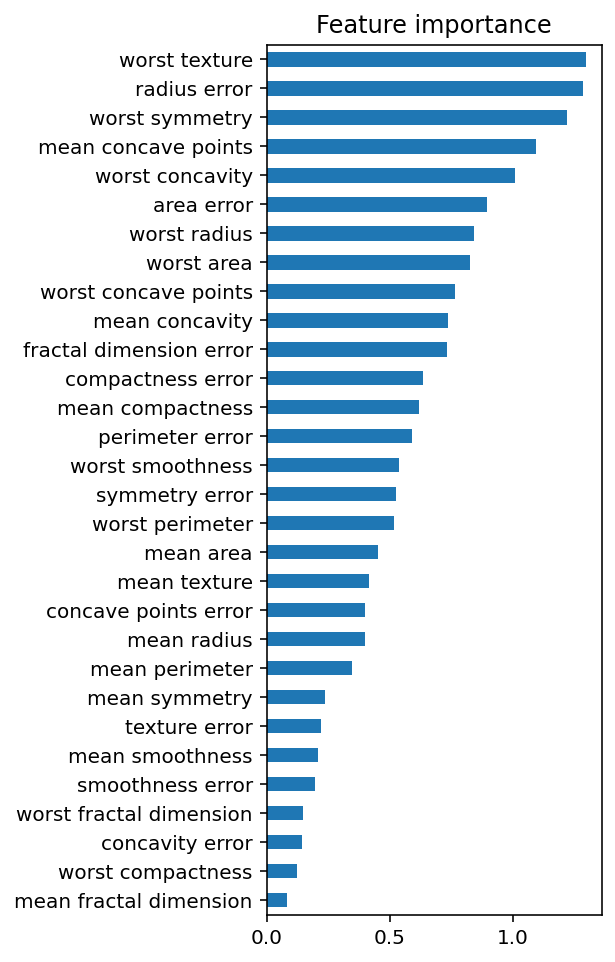

In [13]:
df = pd.Series({k: np.abs(v) for k, v in zip(data["feature_names"], baseline.coef_.flatten())}).sort_values()

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(3, 8))
df.plot.barh(ax=ax)
ax.set_title("Feature importance")

# Other uses

I stepped through this example to provide an illustration of the fact that **if you have high quality features, you probably don't need a neural network.**

* Neural networks essentially train **a linear classifier on the *last* layer.**
* → so neural nets can be thought of "progressively better features."

Neural networks—especially convolutional neural networks—are really good when the features are not high quality.

**Corollary: good features → simple models.**

## Example
e.g., pixels in an image.
 
Let's say I want to detect if a face is "happy," "sad" or "neutral" in an image of the face.

Why would colors aka pixel values be reasonable features? There's a lot of them, and there's no immediate connection without a human.

Instead, why not use the *distances* between different facial landmarks? There's even tools out there to collect 68 facial landmarks! (e.g., [ageitgey/face_recognition][1])

[1]:https://github.com/ageitgey/face_recognition

## One view of neural networks

I think of neural networks as a feature map. I see the layers of a neural net as mapping between these items:

1. First, learn edges.
1. Then learn curves and corners.
1. Then learn about textures and color gradients.
1. Then learn about 3D vision.
1. ...
1. Finally: a good set of features for the classification task.
1. Train a linear classifier.

Distill has a good depiction of this feature map: https://distill.pub/2019/activation-atlas/

* The first layer is "Mixed 3A"; the last layer is "Mixed 5B."
* The first layers learn basics, the later layers almost look like representative images.
    * i.e., "mixed 3a" is most activated by colors/shapes.
    * e.g., "mixed 5b" is most activated by has paintings of the final objects animals.